# **DRDO SSPL Internship: Image Ghosting Correction Prototype**
## Intern: Alex Massy
## Mentor: Mr. Sushil Semwal
### Project Overview: This notebook demonstrates a prototype algorithm for image ghosting correction, focusing on motion blur deconvolution. 
### Setup: Python Libraries (scikit-image==0.25.2, numpy, scipy, matplotlib) | Creating a Conda Environment is necessary.

## **Phase 1**: Image Loading and Degradation

### 1.1: Loading the Original Image & Preprocessing 

Image is color (RGB).
Original Image Shape: (2000, 3000, 3)
Original Image Data Type: float64
Original Image Min Pixel Value: 0.0
Original Image Max Pixel Value: 1.0


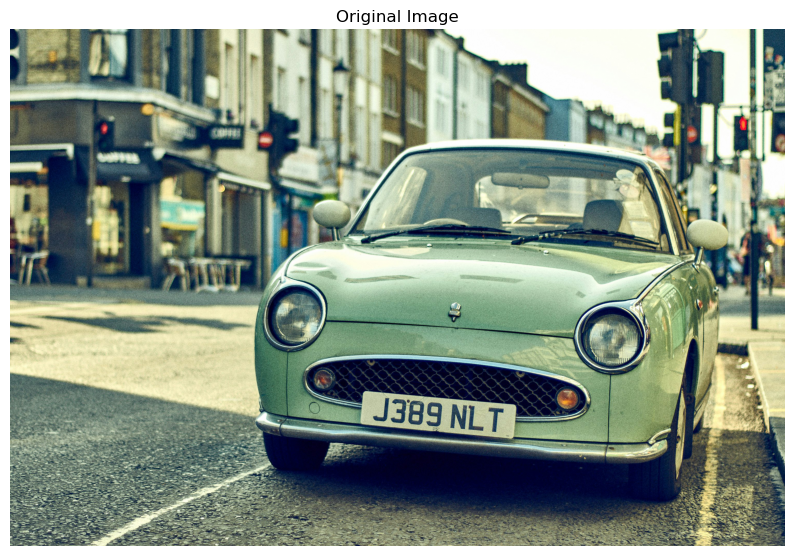

In [1]:
# Imorting necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float 
from skimage.color import rgb2gray

IMAGE_PATH = '/home/alxmassy/Downloads/test.jpeg' # Setting the path to the image file

# Checking if the image file exists and loading it
try:
    img_original_uint8 = io.imread(IMAGE_PATH)
    img_original = img_as_float(img_original_uint8)
except FileNotFoundError:
    print(f"Error: Image not found at {IMAGE_PATH}. Please update IMAGE_PATH.")
    exit()

# Checking if the image is grayscale or color
if img_original.ndim == 3:
    print("Image is color (RGB).")
else:
    print("Image is grayscale.")

# Printing image properties and displaying the image
print(f"Original Image Shape: {img_original.shape}")
print(f"Original Image Data Type: {img_original.dtype}")
print(f"Original Image Min Pixel Value: {np.min(img_original)}")
print(f"Original Image Max Pixel Value: {np.max(img_original)}")
plt.figure(figsize=(10, 8))
plt.imshow(img_original)
plt.title('Original Image')
plt.axis('off')
plt.show()

### 1.2 Creating Artificial Motion Blur (Ghosting)

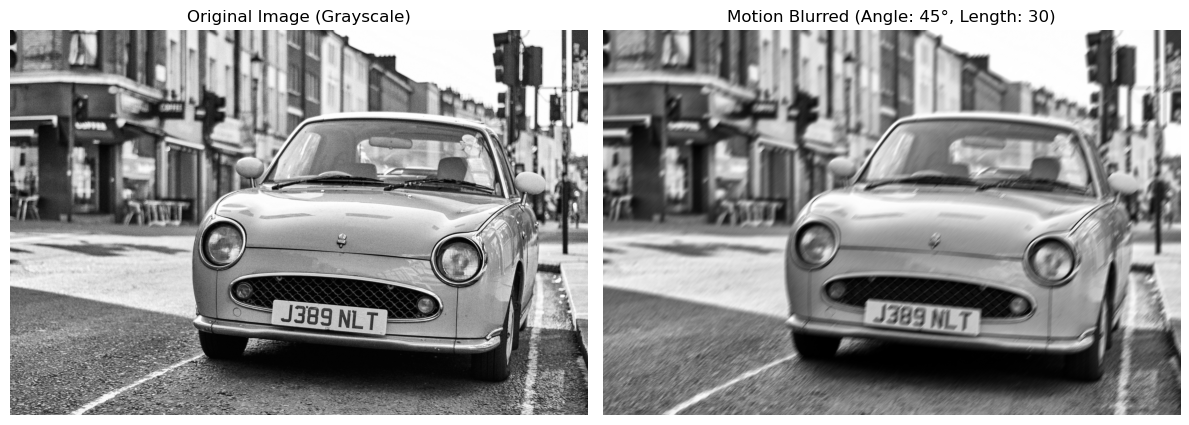

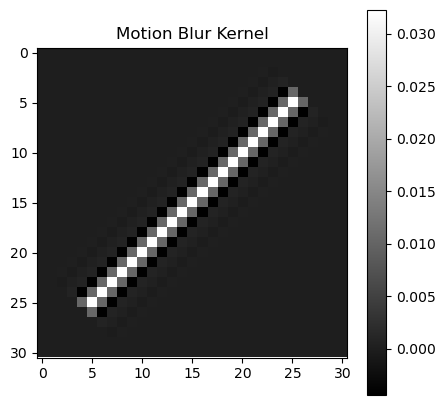

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from scipy.ndimage import rotate, convolve

# Parameters for motion blur
blur_length = 30 
blur_angle = 45

def create_motion_blur_kernel(length, angle):
    # Create a motion blur kernel with the given length and angle.
    # Ensure length is odd
    length = max(3, int(length))
    if length % 2 == 0:
        length += 1
    
    # Create a horizontal kernel
    kernel = np.zeros((length, length))
    kernel[length // 2, :] = 1.0 / length
    
    # Rotate the kernel
    return rotate(kernel, angle, reshape=False)

def apply_motion_blur(image, angle, length):
    # Apply motion blur to an image with given angle and length.
    kernel = create_motion_blur_kernel(length, angle)
    return convolve(image, kernel)

# Create the motion blur kernel
psf = create_motion_blur_kernel(blur_length, blur_angle)

# Apply motion blur to the image
img_gray_for_blur = rgb2gray(img_original) if img_original.ndim == 3 else img_original
img_blurred = apply_motion_blur(img_gray_for_blur, blur_angle, blur_length)

# Display the original and blurred images
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.title('Original Image (Grayscale)')
plt.imshow(img_gray_for_blur, cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title(f'Motion Blurred (Angle: {blur_angle}°, Length: {blur_length})')
plt.imshow(img_blurred, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

# Also display the motion blur kernel
plt.figure(figsize=(5, 5))
plt.title('Motion Blur Kernel')
plt.imshow(psf, cmap='gray')
plt.colorbar()
plt.show()

## Phase 2: Ghosting Fix

### Wiener Filter Deconvolution & Lucy-Richardson Deconvolution


--- Deblurring Evaluation ---
PSNR (Blurred Noisy): 20.82 dB
PSNR (Wiener Deblurred): 17.06 dB
PSNR (Lucy-Richardson Deblurred): 19.29 dB
SSIM (Blurred Noisy): 0.4622
SSIM (Wiener Deblurred): 0.4113
SSIM (Lucy-Richardson Deblurred): 0.5813


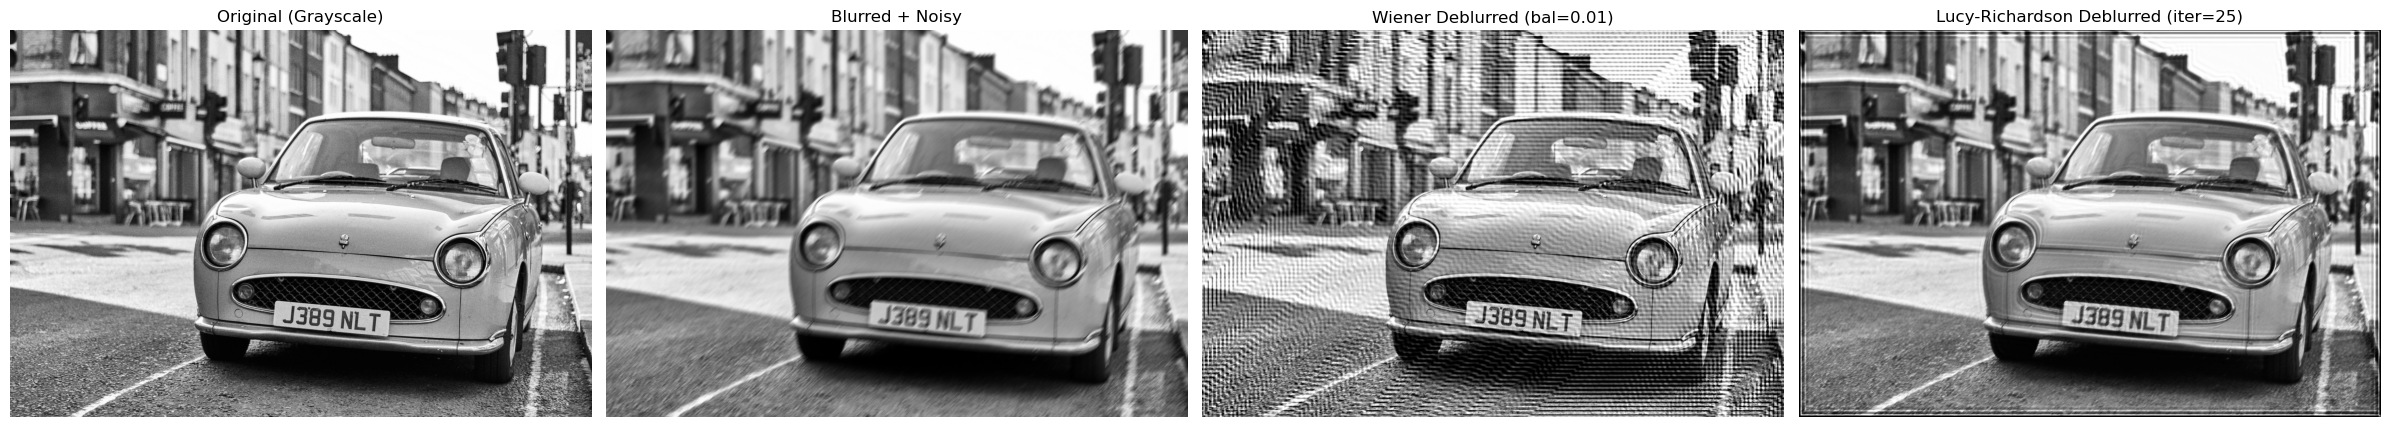

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import wiener, richardson_lucy
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.color import rgb2gray 

# Convert the original image to grayscale if it is in color
img_original_gray = rgb2gray(img_original) if img_original.ndim == 3 else img_original

# Applying weiner deconvolution
wiener_balance = 0.01
img_wiener_deblurred = wiener(img_blurred, psf=psf, balance=wiener_balance)
img_wiener_deblurred = np.clip(img_wiener_deblurred, 0, 1)

# Applying Lucy-Richardson deconvolution
lr_iterations = 25
img_lr_deblurred = richardson_lucy(img_blurred, psf=psf, num_iter=lr_iterations)
img_lr_deblurred = np.clip(img_lr_deblurred, 0, 1)

# Printing evaluation metrics
print("\n--- Deblurring Evaluation ---")
psnr_wiener = peak_signal_noise_ratio(img_original_gray, img_wiener_deblurred)
psnr_lr = peak_signal_noise_ratio(img_original_gray, img_lr_deblurred)
psnr_blurred = peak_signal_noise_ratio(img_original_gray, img_blurred)
print(f"PSNR (Blurred Noisy): {psnr_blurred:.2f} dB")
print(f"PSNR (Wiener Deblurred): {psnr_wiener:.2f} dB")
print(f"PSNR (Lucy-Richardson Deblurred): {psnr_lr:.2f} dB")
ssim_wiener = structural_similarity(img_original_gray, img_wiener_deblurred, data_range=1.0)
ssim_lr = structural_similarity(img_original_gray, img_lr_deblurred, data_range=1.0)
ssim_blurred = structural_similarity(img_original_gray, img_blurred, data_range=1.0)
print(f"SSIM (Blurred Noisy): {ssim_blurred:.4f}")
print(f"SSIM (Wiener Deblurred): {ssim_wiener:.4f}")
print(f"SSIM (Lucy-Richardson Deblurred): {ssim_lr:.4f}")
plt.figure(figsize=(24, 8))

# Displaying the original, blurred, and deblurred images
plt.subplot(1, 4, 1)
plt.imshow(img_original_gray, cmap='gray')
plt.title('Original (Grayscale)')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_blurred, cmap='gray')
plt.title('Blurred + Noisy')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_wiener_deblurred, cmap='gray')
plt.title(f'Wiener Deblurred (bal={wiener_balance})')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img_lr_deblurred, cmap='gray')
plt.title(f'Lucy-Richardson Deblurred (iter={lr_iterations})')
plt.axis('off')

plt.tight_layout()
plt.show()